# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [2]:
import tweepy
import math
import os.path
import pandas as pd
import json
from string import *
from random import shuffle
import sys
from mpmath import *

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: ***@jhp_nt***


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [3]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @jhp_nt

#leitura do arquivo no formato JSON
with open(r'C:\Users\hpaiv\Desktop\Insper\Pass\auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [4]:
#Produto escolhido:
produto = 'Razer'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [5]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [6]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



## Importando a planilha

In [7]:
file = r'Razer.xlsx'
df = pd.read_excel(file)

## Transformando o DataFrame em dois (relevante=0 , irrelevante=1)

In [48]:
CR = df.loc[df['definicao'] == 0]
CI = df.loc[df['definicao'] == 1]

## Criando listas com os Tweets

In [49]:
LR = []
LI = []
PT = []
for i in CR:
    LR.append(i)
for i in CI:
    LI.append(i)
for u in df['treinamento']:
    PT.append(u)


## Função pra limpar as listas

In [10]:
def limpinho(LR):
    i=0
    while (i < len (LR)):
        LR[i]=LR[i].replace("_"," ")
        LR[i]=LR[i].replace("'"," ")
        LR[i]=LR[i].replace("?"," ")
        LR[i]=LR[i].replace("$"," ")
        LR[i]=LR[i].replace("*"," ")
        LR[i]=LR[i].replace("%"," ")
        LR[i]=LR[i].replace("-"," ")
        LR[i]=LR[i].replace("<"," ")
        LR[i]=LR[i].replace(">"," ")
        LR[i]=LR[i].replace("'"," ")
        LR[i]=LR[i].replace('"'," ")
        LR[i]=LR[i].replace("!"," ")
        LR[i]=LR[i].replace("."," ")
        LR[i]=LR[i].replace(","," ")
        LR[i]=LR[i].replace("|"," ")
        LR[i]=LR[i].replace(":"," ")
        LR[i]=LR[i].replace("&"," ")
        LR[i]=LR[i].replace("("," ")
        LR[i]=LR[i].replace(")"," ")
        LR[i]=LR[i].replace("+"," ")
        LR[i]=LR[i].replace("#"," ")
        LR[i]=LR[i].replace("^"," ")
        i+=1
    return LR

## Limpando

In [11]:
LPT=limpinho(PT)
LR=limpinho(LR)
LI=limpinho(LI)

## Função para seraparar os Tweets em palavras

In [12]:
def Palavrinhas(SPT,LPT,PPT):
    SPT=[]
    for w in LPT:
        SPT.append(set(w.split()))
    PPT=[]
    for i in SPT:
        for y in i:
            PPT.append(y)
    return PPT,SPT

## Separando

In [13]:
SR=[]
SI=[]
SPT=[]
PR=[]
PI=[]
PPT=[]
PR=Palavrinhas(SR,LR,PR)
PI=Palavrinhas(SI,LI,PI)
PPT=Palavrinhas(SPT,LPT,PPT)

## Função para criar um dicionario e contar a quantidade de palavras

In [14]:
def DicionarioContador(PR,DICR):
    for j in range(len(PR)-1):
        cont1=j
        cont2=0
        for cont1 in range(len(PR)-1):
            if PR[j] == PR[cont1+1]:
                cont2+=1
        DICR[PR[j]]=mpf(cont2)
    return DICR

## Criando e contando

In [15]:
DICR={}
DICI={}
DICPT={}
DICR=DicionarioContador(PR[0],DICR)
DICI=DicionarioContador(PI[0],DICI)
DICPT=DicionarioContador(PPT[0],DICPT)


## Funções de Probabilidade

In [16]:
def Probabilizando(NP,X):
    for g in NP:
        h=(NP[g]+1)/(len(X)+len(DICPT))
        NP[g]=h
    return NP

def Probabilidade(DICR,PR):
    t=mpf(len(DICR))
    k=mpf(len(PR))
    h=t/k
    return h


## Achando a probabilidade das palavras serem relevantes ou irrelevantes

In [17]:
DICPT=Probabilizando(DICPT,PPT[0])
DICR=Probabilizando(DICR,PI[0])
DICI=Probabilizando(DICI,PR[0])

In [18]:
TOT=df['treinamento']
ProbR=Probabilidade(CR,TOT)
ProbI=Probabilidade(CI,TOT)

## Tabela com os totais

In [19]:
print("Total de palavras é:{0}".format(len(PPT[0])))
print("Total de palavras Irrelevantes é:{0}".format(len(PR[0])))
print("Total de palavras Relevantes é:{0}".format(len(PI[0])))
print("Total de palavras sem repetição é:{0}".format(len(DICPT)))
print("Total de palavras Irrelevantes sem repetição é:{0}".format(len(DICR)))
print("Total de palavras Relevantes sem repetição é:{0}".format(len(DICI)))

Total de palavras é:4259
Total de palavras Irrelevantes é:2290
Total de palavras Relevantes é:1969
Total de palavras sem repetição é:1195
Total de palavras Irrelevantes sem repetição é:832
Total de palavras Relevantes sem repetição é:502


## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante. 

In [20]:
file = r'Razer.xlsx'
df2 = pd.read_excel(file,sheetname="Teste")

## Criando uma lista com Tweets Teste

In [21]:
TET=[]
for u in df2['Teste']:
    TET.append(u)
LTET=limpinho(TET)


## Separando os Tweets em palavras

In [22]:
STET=[]
PTET=[]
PTET=Palavrinhas(STET,LTET,PTET)
DICTET={}

## Função Bayes

In [23]:
def Bayes(ProbR,DICR,X):
    listaV=[]
    for i in PTET[1]:
        j=mpf(len(X))
        v=mpf(len(DICPT))
        cont2=ProbR
        for u in i:
            if u in DICR:

                cont2= cont2*DICR[u]

            else:
                cont2= cont2*(1/(j+v))

        listaV.append(cont2)
    return listaV

## Aplicando Função Bayes

In [24]:
listaR=Bayes(ProbR,DICR,PR[0])
listaI=Bayes(ProbI,DICI,PI[0])


## Lista de Resultado (relevante ou irrelevante)

In [25]:
nova=[]
for i in range(len(listaR)):
    if listaR[i]>listaI[i]:
        nova.append(0)
    elif listaR[i]<listaI[i]:
        nova.append(1)
    else:
        nova.append(0)

## Inserindo Resultados no DataFrame

In [26]:
df2["resultado"]=nova

## Fazendo contagem do resultado

In [27]:
certo=0
errado=0
for i in range(df2["resultado"].count()):
    if df2['Unnamed: 1'][i] == df2['resultado'][i] :
        certo+=1
        
    else:
        errado+=1
    

In [29]:
print (certo)
print (errado)

184
16


In [43]:

Res = []

for i in range(df2["Teste"].count()):
    
    if df2["Unnamed: 1"][i]==1 and df2["resultado"][i]==0:
        Res.append('negativos falsos')

    if df2["Unnamed: 1"][i]==0 and df2["resultado"][i]==0:
        Res.append('positivos verdadeiros')
        
    if df2["Unnamed: 1"][i]==1 and df2["resultado"][i]==1:
        Res.append('negativos verdadeiros')
        
    if df2["Unnamed: 1"][i]==0 and df2["resultado"][i]==1:
        Res.append('positivos falsos')        

df2["Novas_Medidas"] = Res

In [44]:
print('Quantidade dos respectivos Positivos e Negativos (sem porcentagem):')
df2.Novas_Medidas.value_counts()

Quantidade dos respectivos Positivos e Negativos (sem porcentagem):


positivos verdadeiros    110
negativos verdadeiros     74
negativos falsos          14
positivos falsos           2
Name: Novas_Medidas, dtype: int64

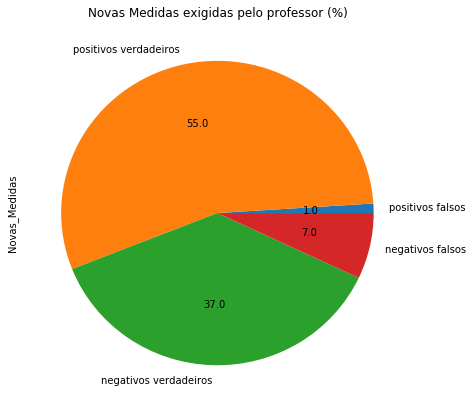

In [45]:
import matplotlib.pyplot as plt
r = df2.Novas_Medidas.value_counts()/len(Res)*100
t = r.reindex(['positivos falsos','positivos verdadeiros','negativos verdadeiros','negativos falsos'])
plot = t.plot(kind='pie',title='Novas Medidas exigidas pelo professor (%)',autopct='%.1f',figsize=(7, 7))
plt.show()

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).


De acordo com os dados obtidos o programa obteve uma alta taxa de eficiência. O fato de que existem mais positivos falsos, pode ser explicado por conta de citações do nome da marca Razer mas que não se referem a produtos nem a marca, como por exemplo nomes de usuários. O baixo número de negativos falsos pode ser explicado por que a grande maioria do conteúdo que não é relevante segue um padrão, e por isso ficam mais fáceis de serem detectados. O alto número de positivos verdadeiros é devido ao fato de que a maior parte das citações são elogios com relação aos produtos Razer.

Um dos problemas que é possível observar, em relação ao programa, é o fato de que certas expressões utilizadas pelos usuários podem apresentar conotações que o programa não interpretaria direito, como por exemplo o sarcasmo, que só é perceptível para por conta da maneira com a qual a frase é escrita ou pela pontuação, porém para que o programa tentasse identificar esse tipo de comportamento seria necessário um maior trabalho com relação ao código para que fosse possível que ele identificasse esses casos de sarcasmo, e ainda assim não seria preciso o suficiente. O programa provavelmente iria demonstrar como avaliações positivas algumas situações onde há sarcasmo. Outro exemplo, é a questão da dupla negação aonde o usuário poderia ter a escrito de maneira proposital ou sem a intenção, esse tipo de comportamento se demonstra muito questionável para que o programa pudesse avaliar com uma precisão adequada a situação. Nesse caso o programa, por exemplo, poderia julgar como negativas comentários que fossem positivas ou vice-versa

Os resultados obtidos se demonstraram muito satisfatórios o suficiente para que exista um financiamento do mesmo, e além do mais o programa mesmo possuindo essa taxa de acertos alta, ainda necessita de melhorias para aumentar ainda mais a sua precisão 

 Ao tentar alimentar a base de treinamento com dados gerados automaticamente pelo classificador alguma palavra pode acabar influenciando na seleção dos tweets que possuem relevância sendo assim a capacidade de discernimento do programa seria muito afetada deixando a sua precisão com relação aos tweets que são realmente relevantes acabaria diminuindo 	
 
 O Teorema de Bayes curiosamente também é utilizado como medida de segurança em algumas empresas aonde se é aplicado o classificador para ver a probabilidade de escolhas mais seguras, com menos incidentes ou com mais chances de dar certo sem eventuais erros. 
 
 Para tornar o programa mais preciso podem ser feitas alterações no programa como por exemplo uma base de dados maior para que a precisão com relação a relevância dos tweets possa melhorar, sendo assim classificando de maneira melhor as palavras.	